In [1]:
import pandas as pd
import numpy as np
import pm4py
from matplotlib import pyplot as plt
from fitter import Fitter
import scipy.stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
def filtering(event_log, ubicazione):
    mask = event_log['ubicazione'] == ubicazione
    get_ID = event_log[mask]['ID_unique'].unique()
    mask_id = event_log['ID_unique'].isin(get_ID)
    new_log = event_log[mask_id]
    return(new_log)

### Importazione dataset

In [3]:
df_traces = pd.read_csv('C:/Users/HP/Desktop/df_traces_end_pes.csv')
df_traces.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
event_log = df_traces[['ID', 'stato', 'ubicazione', 'rif', 'ID_unique', 'timestamp']]
event_log.sort_values(['ID', 'timestamp'], inplace=True)
event_log.reset_index(inplace=True, drop=True)

In [5]:
len(event_log['ID_unique'].unique())

1219

### Pre processing

In [6]:
event_log = df_traces[['ID', 'stato', 'ubicazione', 'rif', 'ID_unique', 'timestamp']]
event_log.sort_values(['ID', 'timestamp'], inplace=True)
event_log.reset_index(inplace=True, drop=True)

#  select only traces with classic extrusor
#  event_log = filtering(event_log, 'estrusore')

'''#  remove traces with 'parking' as activity
for string in ['V_per_park', 'P_per_park']:
    mask_park = np.asarray(event_log[ event_log['stato'] == string].index)
    ID_park = event_log.loc[mask_park]['ID_unique'].values
    mask_drop_park = np.asarray( event_log[ event_log['ID_unique'].isin(ID_park)].index )
    event_log.drop( mask_drop_park, inplace = True )'''

#  remove traces with 'recheck' as activity
mask_recheck = np.asarray( event_log[ event_log['stato'] == 'P_recheck' ].index )
ID_recheck = event_log.loc[mask_recheck]['ID_unique'].values
mask_drop_recheck = np.asarray( event_log[ event_log['ID_unique'].isin(ID_recheck)].index )
event_log.drop( mask_drop_recheck, inplace = True )

#  #  format event log and visualize start/end activities
event_log = pm4py.format_dataframe(event_log, case_id='ID_unique', activity_key='rif', timestamp_key='timestamp')
start_activities = pm4py.get_start_activities(event_log)
end_activities = pm4py.get_end_activities(event_log)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Start activities: {'V_da_pes/ing_zona_misc': 222, 'V_da_pes/nav_serv_parcheggi': 219, 'V_da_pes/nav_serv_carr_vuoti': 151, 'V_da_pes/catenaria_ing_misc': 119, 'V_da_pes/estrusore': 102, 'V_da_pes/miscelatore': 99, 'V_da_pes/nav_serv_carr_pieni': 61, 'V_da_pes/catenaria_vuoti': 52, 'V_da_pes/catenaria_parcheggi': 52, 'V_da_pes/pesatura': 49, 'V_da_pes/carroponte_1': 42, 'V_da_pes/navetta_serv_misc': 22, 'V_da_pes/pinza_vuoti': 13, 'V_remove/catenaria_ing_misc': 3, 'V_per_park/estrusore': 2, 'V_da_pes/buffer': 1, 'P_da_est/manuale': 1, 'P_da_misc/ing_zona_misc': 1, 'P_da_est/nav_serv_parcheggi': 1, 'P_da_misc/miscelatore': 1, 'P_da_misc/navetta_serv_misc': 1, 'V_da_pes/carroponte_2': 1}
End activities: {'V_da_pes/pesatura': 1202, 'V_per_park/catenaria_parcheggi': 7, 'Not_def/fuori_impianto': 5, 'V_da_pes/nav_serv_carr_vuoti': 1}


In [7]:
#  filtering event log by end activiy
from pm4py.algo.filtering.pandas.end_activities import end_activities_filter
event_log = end_activities_filter.apply(event_log, ['V_da_pes/pesatura'],
                                          parameters={end_activities_filter.Parameters.CASE_ID_KEY: "case:concept:name",
                                                      end_activities_filter.Parameters.ACTIVITY_KEY: "concept:name"})
pm4py.get_end_activities(event_log)

{'V_da_pes/pesatura': 1202}

In [8]:
#  filtering event log by start activiy
from pm4py.algo.filtering.pandas.start_activities import start_activities_filter
event_log = start_activities_filter.apply(event_log, ['V_da_pes/nav_serv_parcheggi',
                                                      'V_da_pes/ing_zona_misc',
                                                      'V_da_pes/nav_serv_carr_vuoti',
                                                      'V_da_pes/estrusore',
                                                      'V_da_pes/miscelatore'],
                                          parameters={start_activities_filter.Parameters.CASE_ID_KEY: "case:concept:name",
                                                      start_activities_filter.Parameters.ACTIVITY_KEY: "concept:name"})
pm4py.get_start_activities(event_log)

{'V_da_pes/ing_zona_misc': 221,
 'V_da_pes/nav_serv_parcheggi': 219,
 'V_da_pes/nav_serv_carr_vuoti': 150,
 'V_da_pes/estrusore': 102,
 'V_da_pes/miscelatore': 99}

In [9]:
#  evaluate number of variants
from pm4py.statistics.traces.generic.pandas import case_statistics
variants_count = case_statistics.get_variant_statistics(event_log,
                                          parameters={case_statistics.Parameters.CASE_ID_KEY: "case:concept:name",
                                                      case_statistics.Parameters.ACTIVITY_KEY: "concept:name",
                                                      case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"})
variants_count = sorted(variants_count, key=lambda x: x['case:concept:name'], reverse=True)
len(variants_count)

82

In [10]:
variants_count

[{'variant': 'V_da_pes/ing_zona_misc,V_da_pes/miscelatore,V_da_pes/navetta_serv_misc,V_da_pes/pesatura',
  'case:concept:name': 151},
 {'variant': 'V_da_pes/nav_serv_parcheggi,V_da_pes/catenaria_ing_misc,V_da_pes/navetta_serv_misc,V_da_pes/pesatura',
  'case:concept:name': 120},
 {'variant': 'V_da_pes/miscelatore,V_da_pes/navetta_serv_misc,V_da_pes/pesatura',
  'case:concept:name': 81},
 {'variant': 'V_da_pes/ing_zona_misc,V_da_pes/navetta_serv_misc,V_da_pes/pesatura',
  'case:concept:name': 53},
 {'variant': 'V_da_pes/nav_serv_parcheggi,V_da_pes/catenaria_ing_misc,V_da_pes/pesatura',
  'case:concept:name': 34},
 {'variant': 'V_da_pes/nav_serv_parcheggi,V_da_pes/catenaria_ing_misc,V_da_pes/catenaria_ing_misc,V_da_pes/navetta_serv_misc,V_da_pes/pesatura',
  'case:concept:name': 29},
 {'variant': 'V_da_pes/nav_serv_carr_vuoti,V_da_pes/nav_serv_carr_pieni,V_da_pes/catenaria_vuoti,V_da_pes/nav_serv_parcheggi,V_da_pes/catenaria_ing_misc,V_da_pes/navetta_serv_misc,V_da_pes/pesatura',
  'case

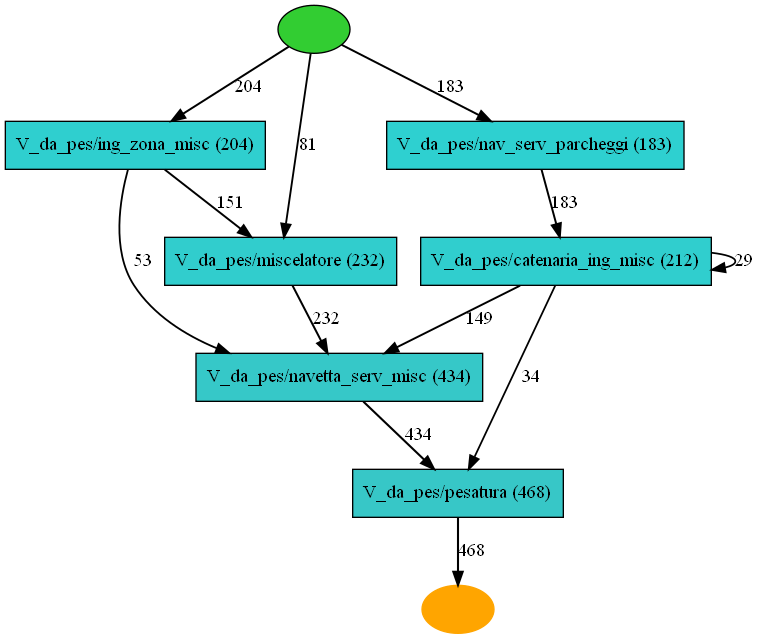

In [13]:
#  visualize heuristic net
filtered_log = pm4py.filter_variants_top_k(event_log, 6)

from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
heu_net = heuristics_miner.apply_heu(filtered_log,
                                     parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT: 4,
                                                heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES: 1,
                                                heuristics_miner.Variants.CLASSIC.value.Parameters.LOOP_LENGTH_TWO_THRESH: 2})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

In [14]:
pm4py.save_vis_heuristics_net(heu_net, 'C:/Users/HP/Desktop/huristicnet_pre_pes.png')

### Calcolo intertempi tra le attività

In [23]:
df_pes = filtered_log[['ID_unique', 'ubicazione', 'rif', 'timestamp']].copy()

t_hand_pes = []

i = 0
for idu in df_pes['ID_unique'].unique():
    mask = df_pes['ID_unique'] == idu
    df_tmp = df_pes[mask].sort_values('timestamp')
    df_tmp.set_index('rif', inplace=True)
    minuendo = None
    sottraendo = None
    if len(df_tmp) == len(df_tmp.index.unique()):
        if 'V_da_pes/ing_zona_misc' in df_tmp.index:
            minuendo = 'V_da_pes/pesatura'
            sottraendo = 'V_da_pes/ing_zona_misc'
        #  --------------------
        elif 'V_da_pes/estrusore' in df_tmp.index:
            minuendo = 'V_da_pes/pesatura'
            sottraendo = 'V_da_pes/estrusore'
        #  -------------------------
        elif 'V_da_pes/miscelatore' in df_tmp.index and 'V_da_pes/in_zona_misc' not in df_tmp.index:
            minuendo = 'V_da_pes/pesatura'
            sottraendo = 'V_da_pes/miscelatore'  
        #  -------------------
        elif 'V_da_pes/nav_serv_carr_vuoti' in df_tmp.index and 'V_da_pes/estrusore' not in df_tmp.index:
            minuendo = 'V_da_pes/pesatura'
            sottraendo = 'V_da_pes/nav_serv_carr_vuoti'
        #  --------------------
        elif 'V_da_pes/nav_serv_parcheggi' in df_tmp.index and 'V_da_pes/nav_serv_carr_vuoti' not in df_tmp.index:
            minuendo = 'V_da_pes/pesatura'
            sottraendo = 'V_da_pes/nav_serv_parcheggi'
       
        if minuendo in df_tmp.index and sottraendo in df_tmp.index:
            dt = np.round(
                (df_tmp.loc[minuendo, 'timestamp'] - df_tmp.loc[sottraendo, 'timestamp']).total_seconds() / 60, 4)
            t_hand_pes.append(dt)

In [25]:
len(t_hand_pes)

374

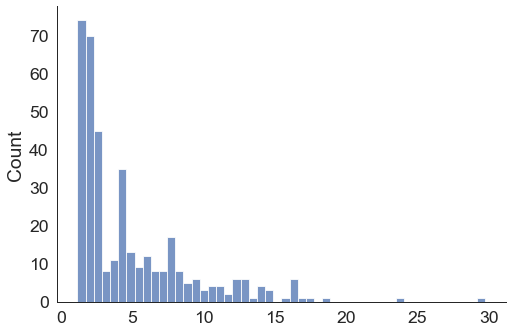

In [27]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=t_hand_pes, kind="hist", bins = 50, aspect = 1.5)

In [ ]:
def quantile2(column,pct,pct_lower):
    y = column
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    return y

,sumsquare_error,aic,bic,kl_div
recipinvgauss,0.407486,969.193971,-2533.656542,inf
pearson3,0.426122,936.465091,-2516.932124,inf
johnsonsu,0.429289,963.337810,-2508.238155,inf
burr12,0.429676,975.329178,-2507.901554,inf
chi,0.431136,1313.019135,-2512.557170,inf


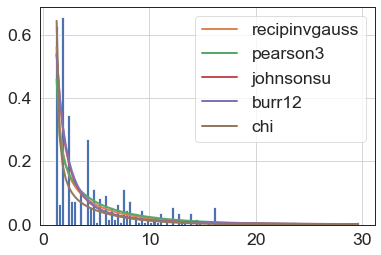

In [28]:
#  extract best fitting distribution from 'estrusione'
f = Fitter(t_hand_pes)
f.fit()
f.summary()

In [29]:
f.get_best(method = 'sumsquare_error')

{'recipinvgauss': {'mu': 982686.023539558,
  'loc': 1.133299999996841,
  'scale': 3.395239969140169}}

In [31]:
np.median(t_hand_pes)

2.85